In [1]:
import codecs
import pandas as pd

from konlpy.tag import Okt as Twitter
from sklearn.feature_extraction.text import CountVectorizer

import torch
import torch.nn as nn
import torch.utils.data as Data

import numpy as np
import random

from sklearn.model_selection import train_test_split

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

# Prepare Data

In [3]:
f = codecs.open('data/reviews.txt', 'r', 'utf-8')
f.read()[:500]

'# G마켓에 좋은 평만 있어서 사봤는데.. 정말 진짜 진짜 사지마세요. 개. 쓰. 레. 기 (진심) 입니다. 액정부터 짜증나는 TN패널에, 하드 SSD인걸로 알았는데, 속도는 저질 SD카드 꽂아 놓은것 같습니다. 정말 느려터집니다. 저는 단지 인터넷 뱅킹만 할려고, 샀단 말입니다. 그런데 인터넷 뱅킹 프로그램까는데만 10~20분 걸립니다. 뭐약!! 이게!! 분노로 인해 볼때마다 짜증납니다. 밤에 잠도 안오고요.. 사시면 분명 후회하실겁니다. 아! 진짜 G마켓 프리미엄평으로 실날하게 사진찍어서 올리려고했는데, 먹고 산다고 바빠서 프리미엄 평 못 올린게 정말 천추의 한이네요!!\n# 원래 그런 줄 알고 사는 "저가 제품"이라고 생각합니다만. IPS라는 언급이 없으니 당연히 TN 패널일 테고, EMMC는 SSD가 아니고 SD 카드 내장된 것 같은 것이라 원래 SSD보다 느린 것이고, CPU도 아톰이니 뭐 당연히 느리죠. 그런 것 다 감안하고 "싸고 가볍다"는 조건으로 사는 제품인데요. 뭐 '

# Extract Sentences

In [4]:
keywords = ["발열", "소음"]

for keyword in keywords:
    temp_list = []
    save_name = "data/reviews_" + keyword + ".txt"
    f = codecs.open("data/reviews.txt", "r", "utf-8")
    t = codecs.open(save_name, "w", "utf-8")
    
    while True:
        line = f.readline()
        if not line: break
        if keyword in line:
            temp_list.append(line)
    set_list = list(set(temp_list))
    
    for item in set_list:
        t.write(item)

    f.close()
    t.close()

In [5]:
f = codecs.open("data/reviews_소음.txt", 'r', 'utf-8')
f.read()[:500]

'# 살려고 고민했는데 잘산거 같아요 쿨러 소리만 조금더 조용하면 진짜 좋을텐데 다른제품 쿨러 비교는 못해봐서 모르겠는데 쿨러소음이 없는걸 구입하고 싶어요\n# 안녕하십니까. 레노버 유통사 반석전자 입니다. 팬소음 이슈는 크게 없는 모델입니다. 이용하시고자 하는 프로그램의 권장사양을 확인해주시기 바라며 동일사양의 플레이 영상을 참조해주시기 바랍니다. https://goo.gl/UKTTh1 ( * GTX 950m + i5-6300HQ ) 감사합니다.\n# 큰맘먹고 노트북 처음샀는데 받자마자 보는순간 너무너무 이쁘네요 발열도 없고 소음도 진짜 없고 너무가벼워서 진짜 잘산거같아요 ~~~\n# 노트북은 처음인데 속도빠르고 소음작고 맘에듭니다 ^^\n# 일단 기계는 양호한편입니다. 근데 소음이 심해요\n# 일단좋네요 이쁘고 가격대비 사양도 좋구요. 팬소음은.. 음 쫌 거슬리네요. 이부분은 감안하셔야 할 것 같습니다.\n# 좋습니다 게임은 디아블로3만해봤는데 끈킴없이 잘돌아갑니다 win10을 처음 사용해보'

# Load Scored Data

In [6]:
filename = 'data/score_소음.xlsx'
sheet_name = 'Sheet1'
data = pd.read_excel(filename, sheet_name=sheet_name, header=0)

csv_data = [item.replace('#', '').strip() for item in data['Review']]
csv_label = data["Score"]

In [7]:
csv_data[:5]

['소음.... 상당히 거슬립니다', '소음은 상당합니다', '소음은 좀 많네요', '소음이 심해요', '소음이 큰편입니다']

In [8]:
csv_label[:5]

0    2
1    2
2    2
3    2
4    2
Name: Score, dtype: int64

In [9]:
scores = [sum(csv_label == 0), sum(csv_label == 1), sum(csv_label == 2)]
scores

[698, 265, 132]

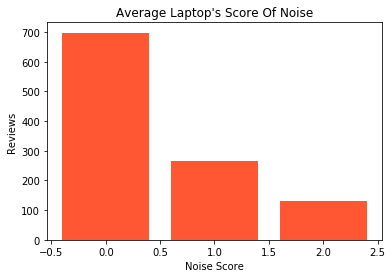

In [10]:
plt.bar(range(len(scores)), scores, color = "#ff5733")
plt.title("Average Laptop's Score Of Noise")
plt.xlabel("Noise Score")
plt.ylabel("Reviews")
plt.show()

# Bag Of Words

In [11]:
twitter = Twitter()
doc = []

for sentence in csv_data:
    results = []
    tokens = twitter.pos(sentence, norm=True, stem=True)
    for token in tokens:
        if not token[1] in ["Josa", "Eomi", "Punctuation"]:
            results.append(token[0])
    doc.append(" ".join(results).strip())

In [12]:
doc[:5]

['소음 상당하다 거슬리다', '소음 상당하다', '소음 좀 많다', '소음 심해', '소음 크다 편입 니']

In [13]:
cnv = CountVectorizer(ngram_range=(1, 1), min_df=3)

data = cnv.fit_transform(doc).toarray()
label = csv_label.values

In [14]:
cnv.vocabulary_

{'소음': 127,
 '상당하다': 117,
 '거슬리다': 13,
 '많다': 74,
 '심해': 136,
 '크다': 212,
 '편입': 215,
 '빼다': 109,
 '심하다': 135,
 '나다': 34,
 '도서관': 52,
 '같다': 11,
 '쓸다': 143,
 '들다': 61,
 '않다': 151,
 '너무': 37,
 '업무': 160,
 '되다': 57,
 '정도': 188,
 '이다': 171,
 '보이다': 99,
 '발열': 91,
 '편이': 214,
 '약간': 153,
 '하지만': 220,
 '게이': 17,
 '노트북': 38,
 '하다': 218,
 '펴다': 213,
 '커서': 206,
 '놀라다': 39,
 '인터넷': 175,
 '검색': 16,
 '해보다': 221,
 '생각': 119,
 '단점': 47,
 '바로': 88,
 '조용하다': 193,
 '괜찮다': 22,
 '사다': 110,
 '없다': 161,
 '알다': 152,
 '충전': 205,
 '심해지다': 137,
 '돌아가다': 56,
 '소리': 126,
 '크게': 210,
 '심다': 134,
 '센터': 125,
 '이렇게': 172,
 '자다': 178,
 '부분': 101,
 '바라다': 87,
 '있다': 177,
 '정말': 189,
 '사용': 112,
 '현재': 223,
 '윈도우': 169,
 '가격': 3,
 '대비': 49,
 '사양': 111,
 '아니다': 144,
 '아주': 147,
 '들리다': 62,
 '그렇다': 27,
 '게임': 18,
 '돌리다': 55,
 '성능': 124,
 '많이': 75,
 '구매': 24,
 '만족': 71,
 '엄청': 158,
 '보다': 96,
 '수준': 129,
 '민감하다': 86,
 '조금': 192,
 '문제': 85,
 '그리고': 28,
 '발생': 90,
 '무게': 82,
 '때문': 66,
 '제품': 191,
 '굉장하다': 23,
 '좋다': 195

# Train-Test Split

In [15]:
dim = len(cnv.vocabulary_)

In [16]:
train_data, test_data, train_label, test_label = train_test_split(data, label, stratify = label)
print(len(train_data))
print(len(test_data))

821
274


In [17]:
x = torch.from_numpy(train_data).type(torch.FloatTensor)
y = torch.from_numpy(train_label).type(torch.LongTensor)

In [18]:
y.size(), x.size()

(torch.Size([821]), torch.Size([821, 231]))

In [19]:
train_data = Data.TensorDataset(x, y)
batch_size = 10
train_loader = Data.DataLoader(dataset=train_data, batch_size = batch_size, shuffle=True, num_workers=1, drop_last=True)

# Define and Train Model

In [20]:
linear1 = nn.Linear(dim, 200, bias=True)
linear2 = nn.Linear(200, 3, bias=True)

relu = nn.ReLU()

model = nn.Sequential(linear1, relu, linear2)

In [21]:
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [22]:
num_epochs = 50

In [23]:
for epoch in range(num_epochs):
    total_batch = len(train_data) // batch_size
    
    for i, (batch_text, batch_labels) in enumerate(train_loader):
        X = batch_text.view(-1, dim)
        Y = batch_labels
        
        pre = model(X)
        cost = loss(pre, Y)
        
        optimizer.zero_grad()
        cost.backward()
        optimizer.step()
        
        if (i + 1) % 20 == 0:
             print('Epoch [%d/%d], lter [%d/%d] Loss: %.4f'
                 %(epoch+1, num_epochs, i+1, total_batch, cost.item()))
    
print("Learning Finished!")

Epoch [1/50], lter [20/82] Loss: 0.9834
Epoch [1/50], lter [40/82] Loss: 0.8389
Epoch [1/50], lter [60/82] Loss: 0.6295
Epoch [1/50], lter [80/82] Loss: 0.4904
Epoch [2/50], lter [20/82] Loss: 0.6149
Epoch [2/50], lter [40/82] Loss: 0.4172
Epoch [2/50], lter [60/82] Loss: 0.4971
Epoch [2/50], lter [80/82] Loss: 0.2605
Epoch [3/50], lter [20/82] Loss: 0.3513
Epoch [3/50], lter [40/82] Loss: 0.4924
Epoch [3/50], lter [60/82] Loss: 0.3678
Epoch [3/50], lter [80/82] Loss: 0.2578
Epoch [4/50], lter [20/82] Loss: 0.2885
Epoch [4/50], lter [40/82] Loss: 0.1850
Epoch [4/50], lter [60/82] Loss: 0.2613
Epoch [4/50], lter [80/82] Loss: 0.2603
Epoch [5/50], lter [20/82] Loss: 0.1040
Epoch [5/50], lter [40/82] Loss: 0.1731
Epoch [5/50], lter [60/82] Loss: 0.1968
Epoch [5/50], lter [80/82] Loss: 0.4155
Epoch [6/50], lter [20/82] Loss: 0.0968
Epoch [6/50], lter [40/82] Loss: 0.2398
Epoch [6/50], lter [60/82] Loss: 0.2277
Epoch [6/50], lter [80/82] Loss: 0.1422
Epoch [7/50], lter [20/82] Loss: 0.1702


# Test Model

In [25]:
x_test = torch.from_numpy(test_data).type(torch.FloatTensor)
y_test = torch.from_numpy(test_label).type(torch.LongTensor)
test_data = Data.TensorDataset(x_test, y_test)

test_loader = Data.DataLoader(dataset=test_data, batch_size = 1, shuffle=True)

In [26]:
model.eval()

correct = 0
total = 0

for text, labels in test_loader:
    text = text.view(-1, dim)
    outputs = model(text)
    
    _, predicted = torch.max(outputs.data, 1)
    total += 1
    correct += (predicted == labels).sum()

print("Accuracy of test text: %f %%" % (100 * float(correct) / total))

Accuracy of test text: 81.751825 %


# Test Sentence

In [28]:
def IsitNoisy(string):
    results = []
    tokens = twitter.pos(string, norm=True, stem=True)
    
    for token in tokens:
        if not token[1] in ["Josa", "Eomi", "Punctuation"]:
            results.append(token[0])
            
    sample = cnv.transform([" ".join(results).strip()]).toarray()
    sample = torch.from_numpy(sample).type(torch.FloatTensor)
    outputs = model(sample)
    pre = torch.max(outputs.data, 1)[1].numpy()
    
    if pre == 0:
        print("분석결과: 소음 거의 없음")
    elif pre == 1:
        print("분석결과: 소음 조금 있음")
    else:
        print("분석결과: 소음 매우 심함")

In [35]:
IsitNoisy("소리가 조금 거슬리더라고요")

분석결과: 소음 조금 있음


In [30]:
IsitNoisy("아주 조용합니다")

분석결과: 소음 거의 없음


In [34]:
IsitNoisy("너무 시끄러워요")

분석결과: 소음 매우 심함
